# Matrix Factorisation - Linear

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [3]:
%matplotlib inline

## Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(np.int64(1), np.int64(5))

In [9]:
train, test = random_split(DATA, [0.8, 0.2])

In [10]:
train.shape, test.shape

((80000, 7), (20000, 7))

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import model_to_dot, plot_model
# from pydot import plot_model

from reco import vis

# Building the model

In [12]:
def ExplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [13]:
n_factors = 40
model = ExplicitMF(n_users, n_items, n_factors)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemEmbedding       │ (None, 1, 40)     │     67,280 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserEmbedding       │ (None, 1, 40)     │     37,720 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemsE       │ (None, 40)        │          0 │ ItemEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsersE       │ (None, 40)        │          0 │ UserEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DotProduct (Dot)    │ (None, 1)         │          0 │ FlattenItemsE[0]… │
│                     │                   │            │ FlattenUsersE[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,000 (410.16 KB)

 Trainable params: 105,000 (410.16 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists d:\Work\Development\recommendation_system/model-img


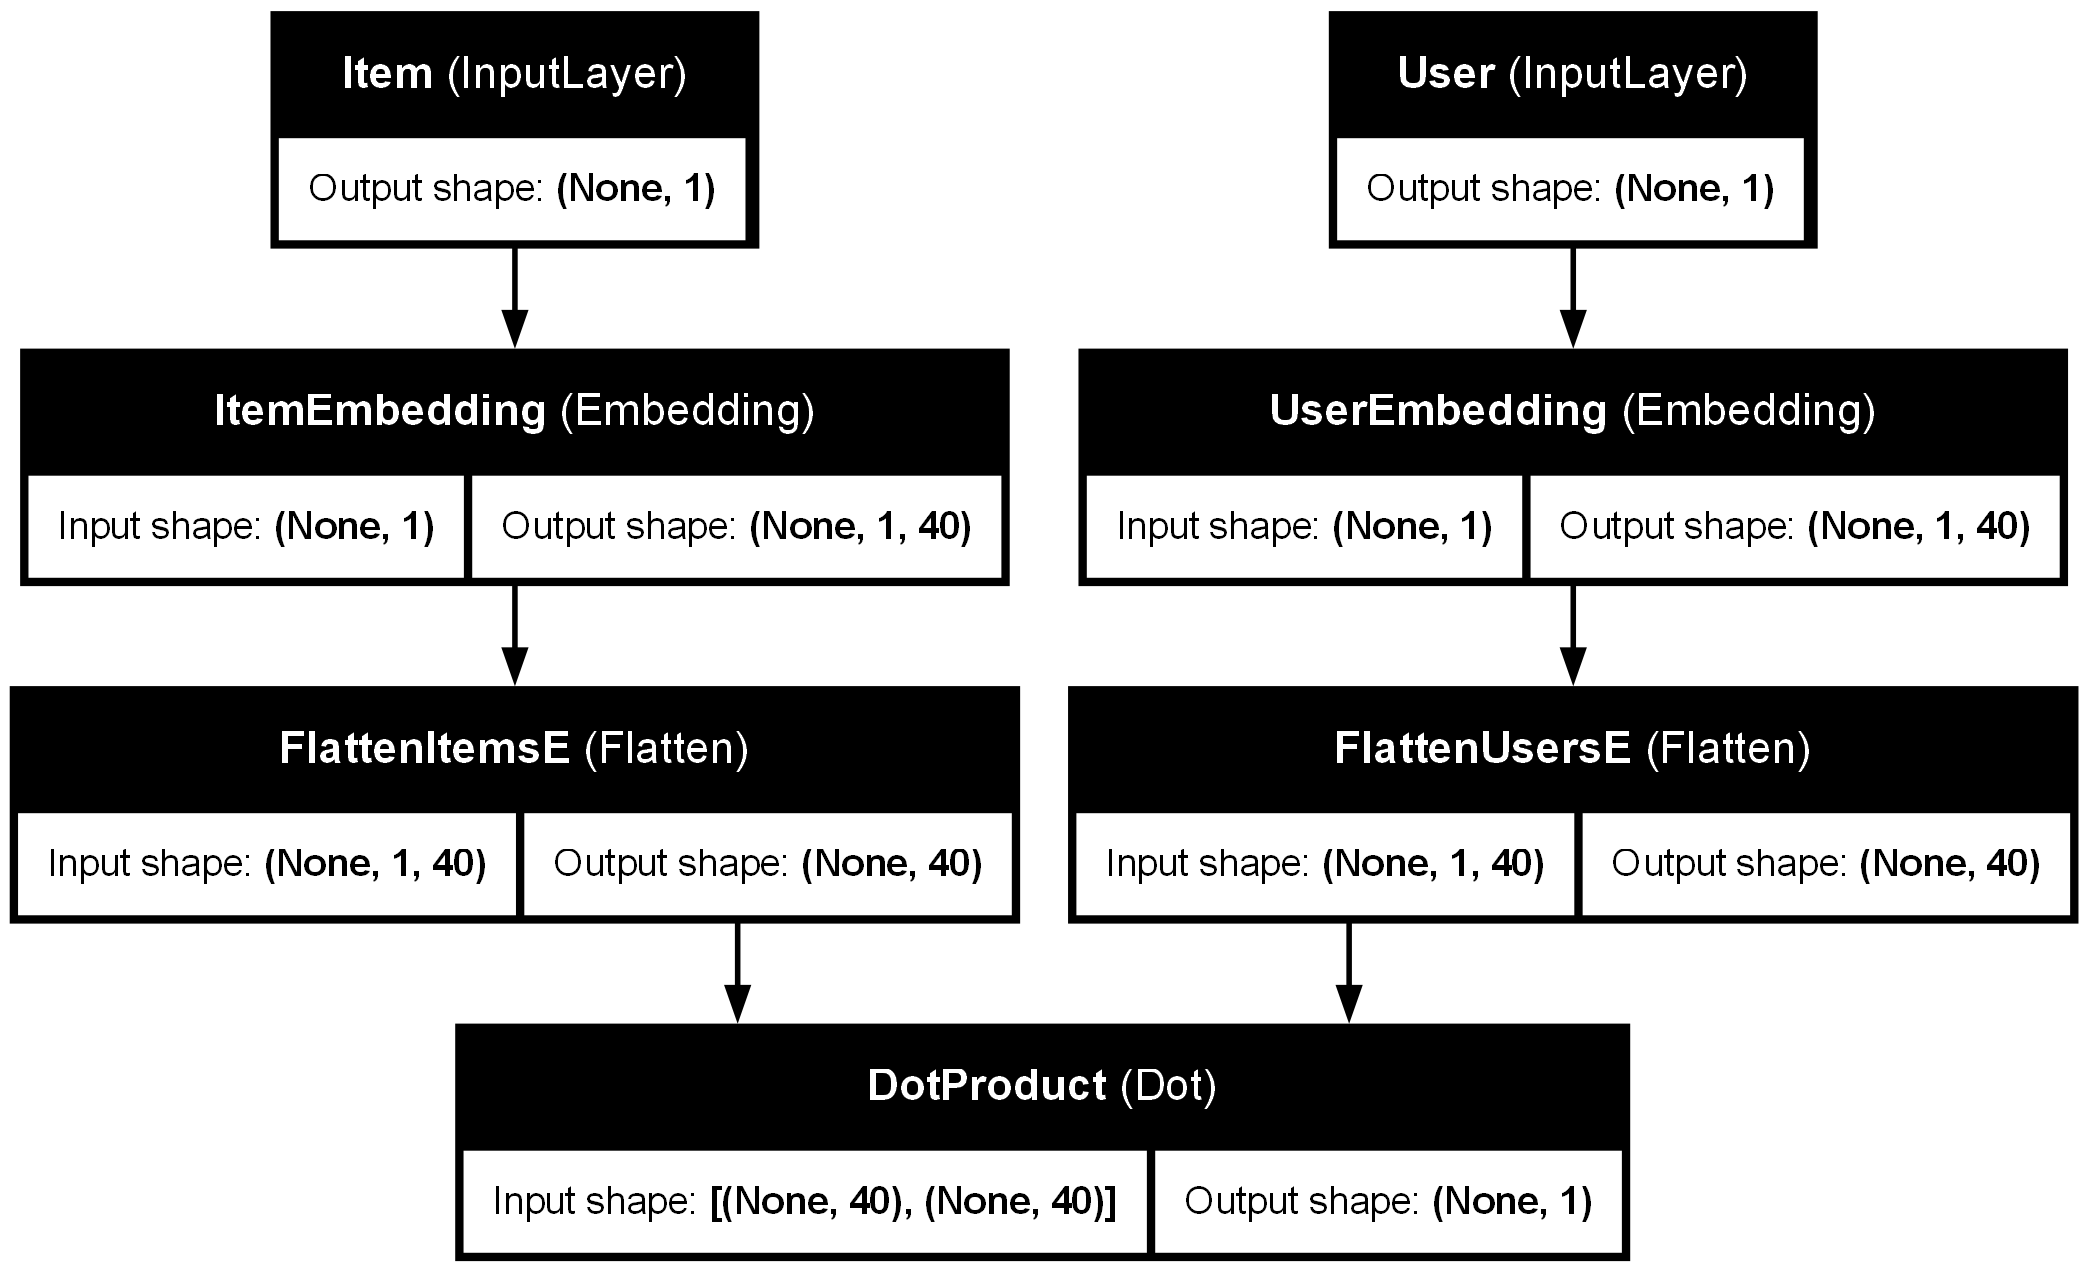

In [16]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/explicit-mf.png" )

# Train the model

In [17]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.6282 - val_loss: 10.1413
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6660 - val_loss: 3.3371
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4243 - val_loss: 2.4946
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0520 - val_loss: 2.2318
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9445 - val_loss: 2.1058
CPU times: total: 10.8 s
Wall time: 4.96 s


In [18]:
vis.metrics(output.history)

alt.FacetChart(...)

## Score the model

In [19]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3325


2.632230520248413

## Evaluate the model

In [20]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [21]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [22]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 33s 674us/step
CPU times: total: 1min 8s
Wall time: 52.3 s


In [23]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.216288
1,195,301,4.167642
2,195,376,1.851642
3,195,50,3.407996
4,195,345,3.737964


In [24]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 30s 613us/step
CPU times: total: 1min 1s
Wall time: 44 s


In [25]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.044353
Precision@K:	0.032686
Recall@K:	0.020155


## Get similar items

In [26]:
from reco.recommend import get_similar, show_similar

In [27]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: total: 46.9 ms
Wall time: 56.2 ms


In [28]:
item_similar_indices

array([[   0,  180,  236,  486,  215],
       [   1, 1034,  552,  940,  231],
       [   2, 1468,  966,  362,   40],
       ...,
       [1679, 1676, 1573, 1634, 1670],
       [1680, 1664, 1634, 1673, 1365],
       [1681, 1200, 1573, 1676, 1634]])

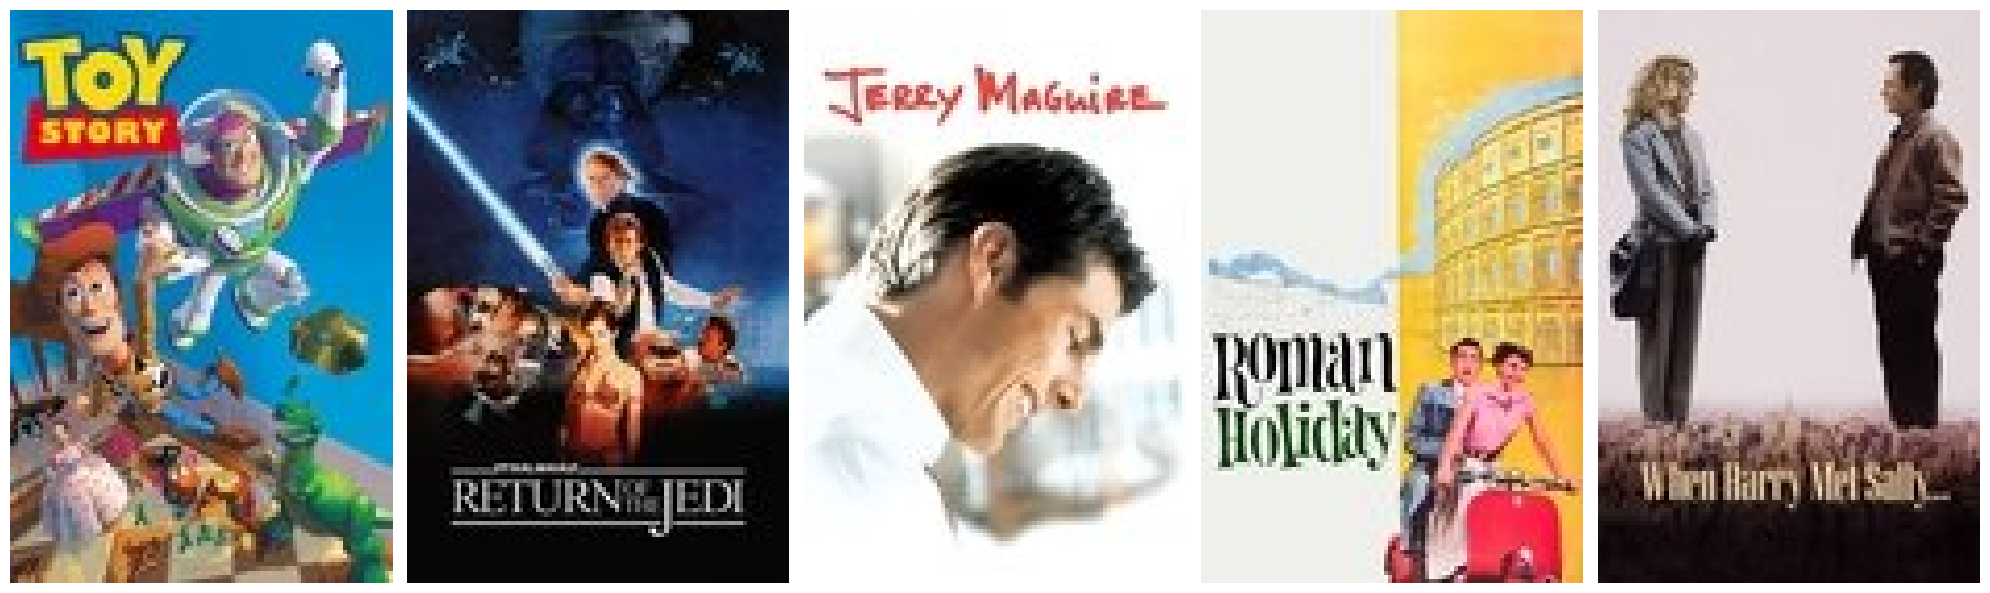

In [29]:
show_similar(0, item_similar_indices, item_encoder)